# Data challenge

Your task is to build an algorithm for prohibitory traffic sign recognition. We have
created a training data set (20 images) that can be used for building and fine-tuning a model.
However, you are encouraged to collect more images, since it will allow you to improve your
model’s performance.

There are 6 traffic sign categories your model should be able to recognize:
* Category A - no right, left, or U-turn
* Category B - speed limit (regardless of the indicated value)
* Category C - road closed
* Category D - no entry
* Category E - no stopping, no parking
* Category F - other types of prohibitory traffic signs

## Here we will implement the [YOLOv8][1] model in KerasCV, an extension of Keras for Computer Vision

We'll follow this tutorial:

https://keras.io/examples/vision/yolov8/

For reference here are some other notebooks that use this model on Kaggle. For some reason all of them have japanese comments but the code is understandable.

https://www.kaggle.com/code/sumtony/keras-cv-yolov8-obj-detection?scriptVersionId=155201062

https://www.kaggle.com/code/cliheng/keras-cv-yolov8-object-detection

A great resource for image augmentation using KerasCV:

https://keras.io/guides/keras_cv/cut_mix_mix_up_and_rand_augment/

[1]: https://keras.io/api/keras_cv/models/backbones/yolo_v8/

## For training and validation we'll use the [Mapillary][2] dataset that was preprcessed and augmented by Izabell Járó.

The train and test sets are combined for training in our case, while the validation set is used for validation.

Our test set will the the 20 images provided by the traffic sign data challenge.

[2]: https://www.mapillary.com/dataset/trafficsign


In [1]:
# Upgrade and install packages
!pip install --upgrade keras-cv
!pip install -U pycocotools    # Official APIs for the MS-COCO dataset

  Obtaining dependency information for keras-cv from https://files.pythonhosted.org/packages/82/22/f50058fd36b840d1edc559c38d121585ab5d974ffd7c31bd4e4ff5027fd4/keras_cv-0.8.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.4/606.4 kB 3.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras-cv
    Found existing installation: keras-cv 0.8.0.dev0
    Uninstalling keras-cv-0.8.0.dev0:
      Successfully uninstalled keras-cv-0.8.0.dev0
  Obtaining dependency information for pycocotools from https://files.pythonhosted.org/packages/ba/64/0451cf41a00fd5ac4501de4ea0e395b7d909e09d665e56890b5d3809ae26/pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 2.9 MB/s eta 0:00:0000:0100:01m


In [2]:
# List the versions of keras for reproducibility
!pip list | grep tensorflow
!pip list | grep keras

tensorflow                               2.13.0
tensorflow-addons                        0.23.0
tensorflow-cloud                         0.1.16
tensorflow-datasets                      4.9.2
tensorflow-decision-forests              1.5.0
tensorflow-estimator                     2.13.0
tensorflow-hub                           0.14.0
tensorflow-io                            0.34.0
tensorflow-io-gcs-filesystem             0.34.0
tensorflow-metadata                      0.14.0
tensorflow-probability                   0.21.0
tensorflow-serving-api                   2.13.0
tensorflow-text                          2.13.0
tensorflow-transform                     0.14.0
tensorflowjs                             4.14.0
keras                                    2.13.1
keras-core                               0.1.7
keras-cv                                 0.8.1
keras-nlp                                0.7.0.dev3
keras-tuner                              1.3.5


In [3]:
# See available GPUs
!nvidia-smi

Thu Jan 11 14:46:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# Import packages
import os
import pandas as pd
import tensorflow as tf
import keras
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_cv
from keras_cv import bounding_box, visualization
import wandb    # For reference: https://docs.wandb.ai/tutorials/keras
from wandb.keras import WandbMetricsLogger
from kaggle_secrets import UserSecretsClient
from pprint import pprint


# Set tensorflow backend for keras
os.environ["KERAS_BACKEND"] = "tensorflow"

# Logging device placement for debugging
#tf.debugging.set_log_device_placement(True)

# Check that tensorflow has GPUs available (The 2xT4 GPUs that Kaggle provides)
devices = tf.config.list_physical_devices('GPU')
print(f'Number of GPUs available: {len(devices)}')
print(f'Names of the devices: {devices}')

GPU_T4 = tf.test.gpu_device_name()
GPU_T4

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend
Number of GPUs available: 2
Names of the devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


'/device:GPU:0'

In [5]:
# Track hyperparameters
config = {
        # Random seed
        "seed": 42,
        # For loading in the images
        "num_classes": 6,
        "image_size": 640,
        "image_channels": 3,
        "batch_size": 8,
        "bbox_format": "xyxy",
        # Size of the training set (max is 26714), set to 'all' if you need all
        "train_size": 1_000,
        # Size of the validation set (max is 922), set to 'all' if you need all
        "val_size": 100,
        # For the prediction decoder
        "iou_threshold": 0.5,
        "confidence_threshold": 0.6,
        # For the Adam optimizer
        "learning_rate": 0.001,
        "global_clipnorm": 10.0,
        # For freezing layers (max is 169 for yolo_v8_s_backbone_coco)
        'freeze_layers': 145,
        # For evaluating the BoxCOCOMetrics
        'eval_freq': 1e9,
        # For fitting the model
        "checkpoint_path": 'yolo-traffic-sign.h5',
        "num_epochs": 100,
        "early_stopping_patience": 30,
        "log_frequency": 5,
}


# Set the random seed for reproducibility
keras.utils.set_random_seed(seed=config['seed'])

# Use Weights & Biases for logging
user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("wandb_key")

wandb.login(key=wandb_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Load in the Traffic Sign Data from the Data Challenge as a Test set

In [6]:
# Set the path to the folder containing the training images
path_images = '/kaggle/input/traffic-signs-data-challenge/train'

# Set the class ids
class_ids = [
    'no-right-left-or-u-turn',
    'speed-limit',
    'road-closed',
    'no-entry',
    'no-stopping-no-parking',
    'other'
]

# Create a dictionary mapping the class ids to integers
class_mapping = dict(zip(range(len(class_ids)), class_ids))
class_mapping

{0: 'no-right-left-or-u-turn',
 1: 'speed-limit',
 2: 'road-closed',
 3: 'no-entry',
 4: 'no-stopping-no-parking',
 5: 'other'}

In [7]:
# Read the annotation file into a pandas dataframe
annot_file = '/kaggle/input/traffic-signs-data-challenge/train/_annotations.csv'
annot_df = pd.read_csv(annot_file)

annot_df.head()

filename  width  height  \
0  17_jpg.rf.06cf807529216c05e2421a97e9a3c9aa.jpg    600     300   
1  17_jpg.rf.06cf807529216c05e2421a97e9a3c9aa.jpg    600     300   
2  17_jpg.rf.06cf807529216c05e2421a97e9a3c9aa.jpg    600     300   
3   6_jpg.rf.8249332fe6bb156f9730dd96d112223f.jpg    600     300   
4   6_jpg.rf.8249332fe6bb156f9730dd96d112223f.jpg    600     300   

                    class  xmin  ymin  xmax  ymax  
0                no-entry    22   149    60   177  
1  no-stopping-no-parking   520   160   570   198  
2                   other   522   236   571   274  
3             road-closed   506   121   542   153  
4                   other   555    97   597   131

In [8]:
# Group the annotations by filename and aggregate the class ids into a list
test_df = annot_df.groupby(['filename']).agg({col:lambda x: list(x) for col in annot_df.columns[1:]}).reset_index()

test_df.head()

filename            width  \
0  10_jpg.rf.73da5bf11a250d18d212bd276be2a02e.jpg  [600, 600, 600]   
1  11_jpg.rf.788b737ab908f716125157158a741b1d.jpg       [600, 600]   
2  12_jpg.rf.f2fd7c2e462831e1225e480312289ad9.jpg       [600, 600]   
3  13_jpg.rf.d5301f84fec055b793adabfb5e4ef329.jpg  [600, 600, 600]   
4  14_jpg.rf.b69dd2f82bdc031b0ccd416aaa8ffaf5.jpg  [600, 600, 600]   

            height                                              class  \
0  [300, 300, 300]  [road-closed, no-stopping-no-parking, speed-li...   
1       [300, 300]                 [no-stopping-no-parking, no-entry]   
2       [300, 300]              [speed-limit, no-stopping-no-parking]   
3  [300, 300, 300]       [speed-limit, other, no-stopping-no-parking]   
4  [300, 300, 300]                        [other, other, speed-limit]   

              xmin             ymin             xmax             ymax  
0  [211, 515, 515]   [175, 107, 68]  [240, 557, 555]  [203, 143, 104]  
1         [543, 6]        [67, 112]        [600, 42]       [142, 146]  
2       [521, 524]       [147, 186]       [556, 556]       [177, 214]  
3  [431, 432, 430]   [149, 120, 91]  [459, 460, 460]  [176, 149, 120]  
4  [463, 456, 319]  [104, 158, 124]  [487, 496, 327]  [158, 213, 134]

In [9]:
def parse_annotation_csv(row, img_path):
    """
    Function to parse the annotation csv file
    :param row: Current row of the annotation csv file
    :img_path: Path to the image folder containing the images
    :return: Image path, bounding boxes, and class ids
    """
    # Get the path of the image
    image_name = row['filename']
    image_path = os.path.join(img_path, image_name)
    
    # Get the bounding box of the traffic sign
    xmin = row['xmin']
    ymin = row['ymin']
    xmax = row['xmax']
    ymax = row['ymax']
    
    # Combine coordinates into a list
    boxes = [[xmin[i], ymin[i], xmax[i], ymax[i]] for i in range(len(xmin))]
    
    # Get the class id of the traffic sign
    classes = row['class']
    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    
    return image_path, boxes, class_ids

def create_ragged_tensor_from_df(df, img_path):
    """
    Function to create a ragged tensor from the DataFrame
    :param df: DataFrame to convert
    :img_path: Path to the image folder containing the images
    :return: A Tensflow ragged tensor
    """
    # Initialize lists to store information
    image_paths, bbox, classes = [], [], []
    # Process annotations for each row in the DataFrame
    for index, row in df.iterrows():
        image_path, boxes, class_ids = parse_annotation_csv(row, img_path)

        image_paths.append(image_path)
        bbox.append(boxes)
        classes.append(class_ids)
    
    print('image_paths first 10')
    pprint(image_paths[:10])
    print('bbox first 10')
    pprint(bbox[:10])
    print('classes first 10')
    pprint(classes[:10])
    # Ragged tensors are used to create a tf.data.Dataset using 
    # the from_tensor_slices method. This method creates a dataset 
    # from the input tensors by slicing them along the first dimension. 
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)
    image_paths = tf.ragged.constant(image_paths)
    print('bbox shape:', bbox.shape)
    # Create a dataset from the ragged tensors
    data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))
    
    return data

print('Test Data:')
test_data = create_ragged_tensor_from_df(test_df, path_images)

Test Data:
image_paths first 10
['/kaggle/input/traffic-signs-data-challenge/train/10_jpg.rf.73da5bf11a250d18d212bd276be2a02e.jpg',
 '/kaggle/input/traffic-signs-data-challenge/train/11_jpg.rf.788b737ab908f716125157158a741b1d.jpg',
 '/kaggle/input/traffic-signs-data-challenge/train/12_jpg.rf.f2fd7c2e462831e1225e480312289ad9.jpg',
 '/kaggle/input/traffic-signs-data-challenge/train/13_jpg.rf.d5301f84fec055b793adabfb5e4ef329.jpg',
 '/kaggle/input/traffic-signs-data-challenge/train/14_jpg.rf.b69dd2f82bdc031b0ccd416aaa8ffaf5.jpg',
 '/kaggle/input/traffic-signs-data-challenge/train/15_jpg.rf.162c7db1dc3d488435d85966979936da.jpg',
 '/kaggle/input/traffic-signs-data-challenge/train/16_jpg.rf.12b7ef37dd31287b55ace3deb5eaf975.jpg',
 '/kaggle/input/traffic-signs-data-challenge/train/17_jpg.rf.06cf807529216c05e2421a97e9a3c9aa.jpg',
 '/kaggle/input/traffic-signs-data-challenge/train/18_jpg.rf.7f567daed1f036392e4c88d133258cb1.jpg',
 '/kaggle/input/traffic-signs-data-challenge/train/19_jpg.rf.b5ae2cd

# Load in the Mapillary data as a Train and Validation set

In [10]:
mapillary_img_path = '/kaggle/input/mapillary-labels/images/images'

# Read the annotation file into a pandas dataframe
mapillary_annot_file = '/kaggle/input/mapillary-labels/object_all.csv'

# Load in the .csv file
mapillary_df = pd.read_csv(mapillary_annot_file, usecols=[1,2,3,4,5,6,7,8])

# rename the name column to filename
mapillary_df.rename(columns={'name': 'filename'}, inplace=True)

# Rename filenames that end with '_aug' to end with '_augreduced' and add '.jpg'
mapillary_df.replace(to_replace=r'_aug$', value='_augreduced', regex=True, inplace=True)
mapillary_df['filename'] = mapillary_df['filename'] + '.jpg'

# The boundig box coordinates need to be integers
mapillary_df[['xmin', 'ymin', 'xmax', 'ymax']] = mapillary_df[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)

mapillary_df.head()

filename  width  height        class  \
0  hzlM917YtiazVQzFBL8kCw_3819_augreduced.jpg   4032    3024  road-closed   
1  HcYl32I27DcQPFISMtgacw_3748_augreduced.jpg   4032    3024  road-closed   
2  5EMpP9GmwHDBQz8YcZ3_oQ_2289_augreduced.jpg   4032    3024  road-closed   
3  9wyk0xrm1mdAu3C3GbVlqQ_2500_augreduced.jpg   3264    2448  road-closed   
4  zUfI8ZBn02wK2VTzv6GgvQ_2240_augreduced.jpg   5248    3936  road-closed   

   xmin  ymin  xmax  ymax  
0   621  2752   679  2845  
1  2968  1259  3124  1416  
2  2231   993  2404  1159  
3  2331  1849  2477  1988  
4  3731   953  3781  1019

In [11]:
mapillary_grouped_df = mapillary_df.groupby(['filename']).agg({col:lambda x: list(x) for col in annot_df.columns[1:]}).reset_index()

mapillary_grouped_df.head()

filename   width  height       class  \
0                  --7fWq6WjZM8L1eUSuvOEA.jpg  [4160]  [3120]     [other]   
1  --7fWq6WjZM8L1eUSuvOEA_1475_augreduced.jpg  [4160]  [3120]     [other]   
2   --7fWq6WjZM8L1eUSuvOEA_177_augreduced.jpg  [4160]  [3120]     [other]   
3                  -0G6gt8ksR0hO5jMKrTDMw.jpg  [4032]  [3024]  [no-entry]   
4                  -0oqTZyDwf6SJlJXaHSTVg.jpg  [3840]  [2160]  [no-entry]   

     xmin    ymin    xmax    ymax  
0  [1480]  [1327]  [1576]  [1421]  
1  [1334]  [1302]  [1427]  [1382]  
2  [2215]  [1044]  [2330]  [1149]  
3  [1776]  [1932]  [1800]  [1956]  
4  [1267]   [890]  [1305]   [951]

In [12]:
# Read the list of filenames from the validation.txt file
# Replace 'validation.txt' with the actual path to your txt file
val_pics_path = '/kaggle/input/mapillary-labels/validation.txt'

with open(val_pics_path, 'r') as file:
    validation_filenames = [line.strip()+'.jpg' for line in file]
    
val_df = mapillary_grouped_df[mapillary_grouped_df['filename'].isin(validation_filenames)]
train_df = mapillary_grouped_df[~mapillary_grouped_df['filename'].isin(validation_filenames)]

In [13]:
train_df.info()
print('='*40)
val_df.info()
print('='*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26714 entries, 0 to 27635
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  26714 non-null  object
 1   width     26714 non-null  object
 2   height    26714 non-null  object
 3   class     26714 non-null  object
 4   xmin      26714 non-null  object
 5   ymin      26714 non-null  object
 6   xmax      26714 non-null  object
 7   ymax      26714 non-null  object
dtypes: object(8)
memory usage: 1.8+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 922 entries, 8 to 27624
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  922 non-null    object
 1   width     922 non-null    object
 2   height    922 non-null    object
 3   class     922 non-null    object
 4   xmin      922 non-null    object
 5   ymin      922 non-null    object
 6   xmax      922 non-null    object
 7   ymax      922 non-null    obj

## Create ragged tensors from the train and validation dataframes

In [14]:
print('Train Data:')
# Check if we use all of the training images
if config['train_size'] == 'all':
    train_data = create_ragged_tensor_from_df(train_df, mapillary_img_path)
# If not then use the fist n that are less than all the training images
elif isinstance(config['train_size'], int) and config['train_size'] <= len(train_df):
    train_data = create_ragged_tensor_from_df(train_df.head(config['train_size']), mapillary_img_path)    # The size of the training set can be changed in  the config (max is 26714) 
else:
    raise ValueError('Size of the training set inside the config is invalid.')
    

print('Val Data:')    
# Check if we use all of the training images
if config['val_size'] == 'all':
    val_data = create_ragged_tensor_from_df(val_df, mapillary_img_path)
# If not then use the fist n that are less than all the training images
elif isinstance(config['val_size'], int) and config['val_size'] <= len(val_df):
    val_data = create_ragged_tensor_from_df(val_df.head(config['val_size']), mapillary_img_path)
else:
    raise ValueError('Size of the validation set inside the config is invalid.')

Train Data:
image_paths first 10
['/kaggle/input/mapillary-labels/images/images/--7fWq6WjZM8L1eUSuvOEA.jpg',
 '/kaggle/input/mapillary-labels/images/images/--7fWq6WjZM8L1eUSuvOEA_1475_augreduced.jpg',
 '/kaggle/input/mapillary-labels/images/images/--7fWq6WjZM8L1eUSuvOEA_177_augreduced.jpg',
 '/kaggle/input/mapillary-labels/images/images/-0G6gt8ksR0hO5jMKrTDMw.jpg',
 '/kaggle/input/mapillary-labels/images/images/-0oqTZyDwf6SJlJXaHSTVg.jpg',
 '/kaggle/input/mapillary-labels/images/images/-0oqTZyDwf6SJlJXaHSTVg_1629_augreduced.jpg',
 '/kaggle/input/mapillary-labels/images/images/-0oqTZyDwf6SJlJXaHSTVg_188_augreduced.jpg',
 '/kaggle/input/mapillary-labels/images/images/-0oqTZyDwf6SJlJXaHSTVg_3070_augreduced.jpg',
 '/kaggle/input/mapillary-labels/images/images/-1dYvHaY52PTrihdjPDPQg.jpg',
 '/kaggle/input/mapillary-labels/images/images/-1dYvHaY52PTrihdjPDPQg_1943_augreduced.jpg']
bbox first 10
[[[1480, 1327, 1576, 1421]],
 [[1334, 1302, 1427, 1382]],
 [[2215, 1044, 2330, 1149]],
 [[1776, 193

In [15]:
def load_image(image_path):
    """
    Function to load the image
    :param image_path: Path to the image
    :return: Tensorflow tensor of the image
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=config['image_channels'])
    return image

def load_dataset(image_path, classes, bbox):
    """
    Function to load the dataset into a dictionary
    :param image_path: Path to the image
    :param classes: List of class ids
    :param bbox: List of bounding boxes
    :return: Dictionary containing the image and bounding boxes as float32 tensors
    """
    print('bbox:', bbox)
    print('bbox shape:', bbox.shape)
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

## "Augmentation" with the Natie KerasCV methods that are aware of the bounding boxes.
It doesn't create more images it just transforms the original ones

In [16]:
# Create an augmenter using the KerasCV layers for the training set
augmenter = keras.Sequential(
    layers=[
        # Randomly flip the image horizontally
        keras_cv.layers.RandomFlip(
            mode="horizontal", bounding_box_format=config["bbox_format"]
        ),
        # Randomly shear the image
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format=config["bbox_format"]
        ), 
        # Randomly zoom into the image
        keras_cv.layers.JitteredResize(
            target_size=(config['image_size'], config['image_size']),
            scale_factor=(0.75, 1.3), bounding_box_format=config["bbox_format"]
        ),
    ]
)

# Create a resizer layer for the validation and test sets
# Source: https://keras.io/api/keras_cv/layers/preprocessing/resizing/
resizer = keras_cv.layers.Resizing(
    height=config['image_size'],
    width=config['image_size'],
    pad_to_aspect_ratio=True,
    bounding_box_format=config["bbox_format"],
)

# This layer implements resize with scale distortion
# Source: https://keras.io/api/keras_cv/layers/augmentation/jittered_resize/
jittered_resizer = keras_cv.layers.JitteredResize(
    target_size=(config['image_size'], config['image_size']),
    scale_factor=(0.75, 1.3),
    bounding_box_format=config["bbox_format"],
)

## Creating Training Validation and Test Dataset

In [17]:
def preprocess_dataset(data, preprocessor, batch_size):
    """
    Function to preprocess the dataset
    :param data: Dataset to preprocess
    :param preprocessor: Preprocessing layer to apply
    :param batch_size: Batch size to map to
    :return: Preprocessed dataset
    """
    # Load the dataset
    dataset = data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    # Shuffle the dataset
    dataset = dataset.shuffle(batch_size * 4)
    # Batch the dataset
    dataset = dataset.ragged_batch(batch_size, drop_remainder=True)
    # Augment the dataset
    dataset = dataset.map(preprocessor, num_parallel_calls=tf.data.AUTOTUNE)
    
    return dataset

# We don't need to use the "augmenter" sequetial model, since the training data is already augmented
train_ds = preprocess_dataset(train_data, resizer, config['batch_size'])
val_ds = preprocess_dataset(val_data, resizer, config['batch_size'])
test_ds = preprocess_dataset(test_data, resizer, 4)

bbox: tf.RaggedTensor(values=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:1", shape=(None,), dtype=int32), row_splits=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:0", shape=(None,), dtype=int64))
bbox shape: (None, None)
bbox: tf.RaggedTensor(values=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:1", shape=(None,), dtype=int32), row_splits=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:0", shape=(None,), dtype=int64))
bbox shape: (None, None)
bbox: tf.RaggedTensor(values=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:1", shape=(None,), dtype=int32), row_splits=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:0", shape=(None,), dtype=int64))
bbox shape: (None, None)


## Visualization of the training dataset

Some examples of the augmented training data. All the images are reshaped into 640x640 pixels with this letterboxing technique that fills the remaining part of the image black.

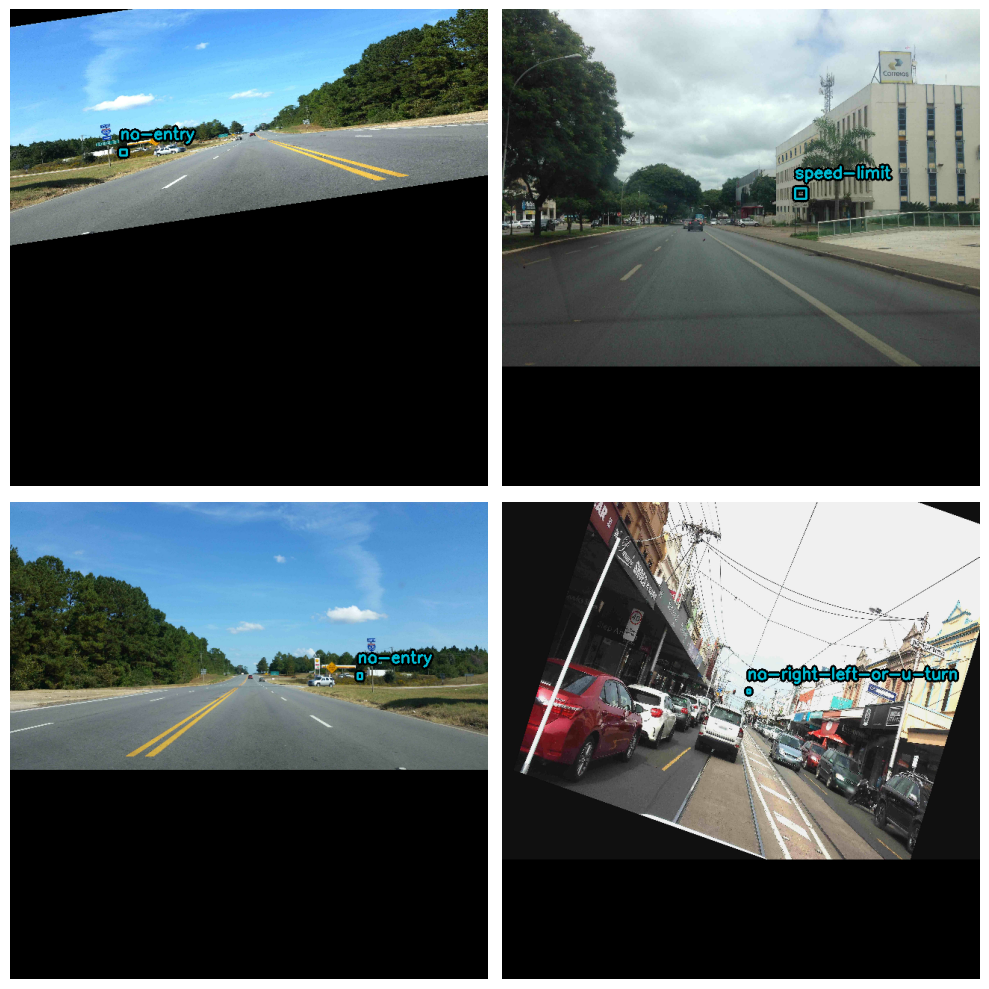

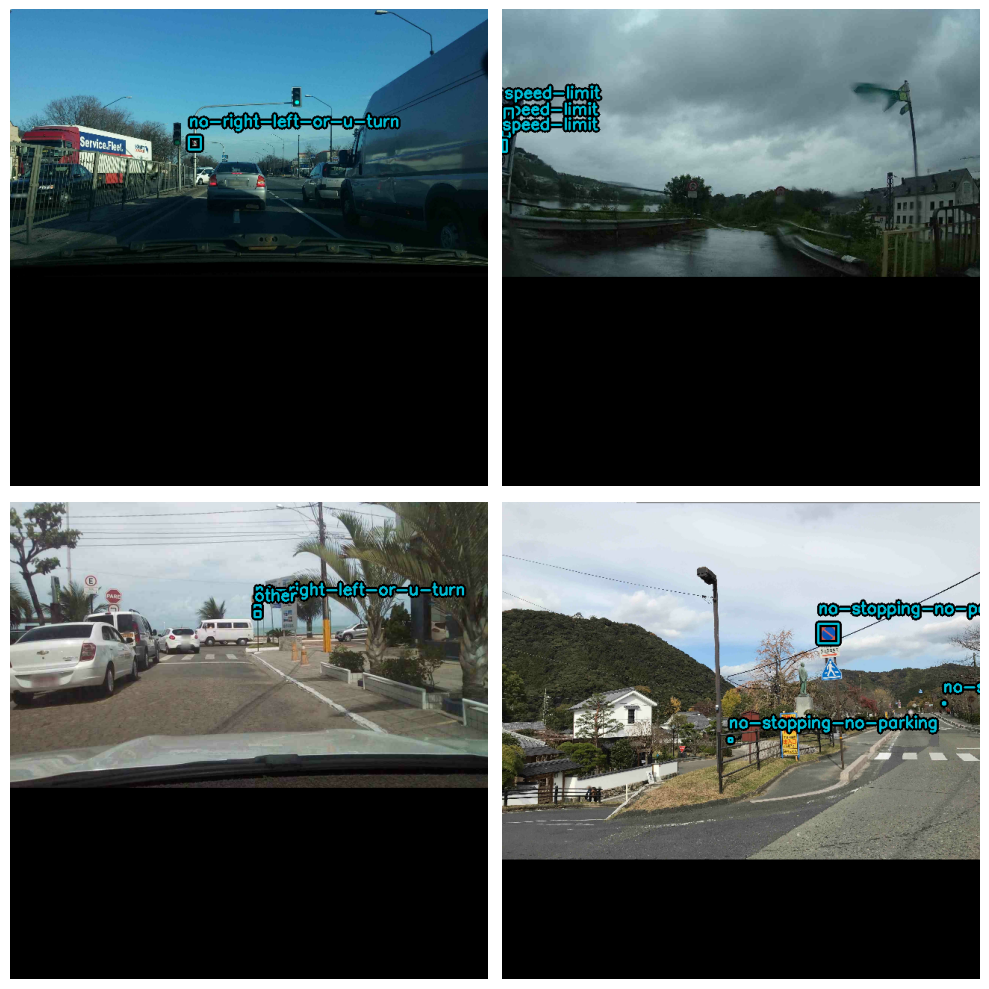

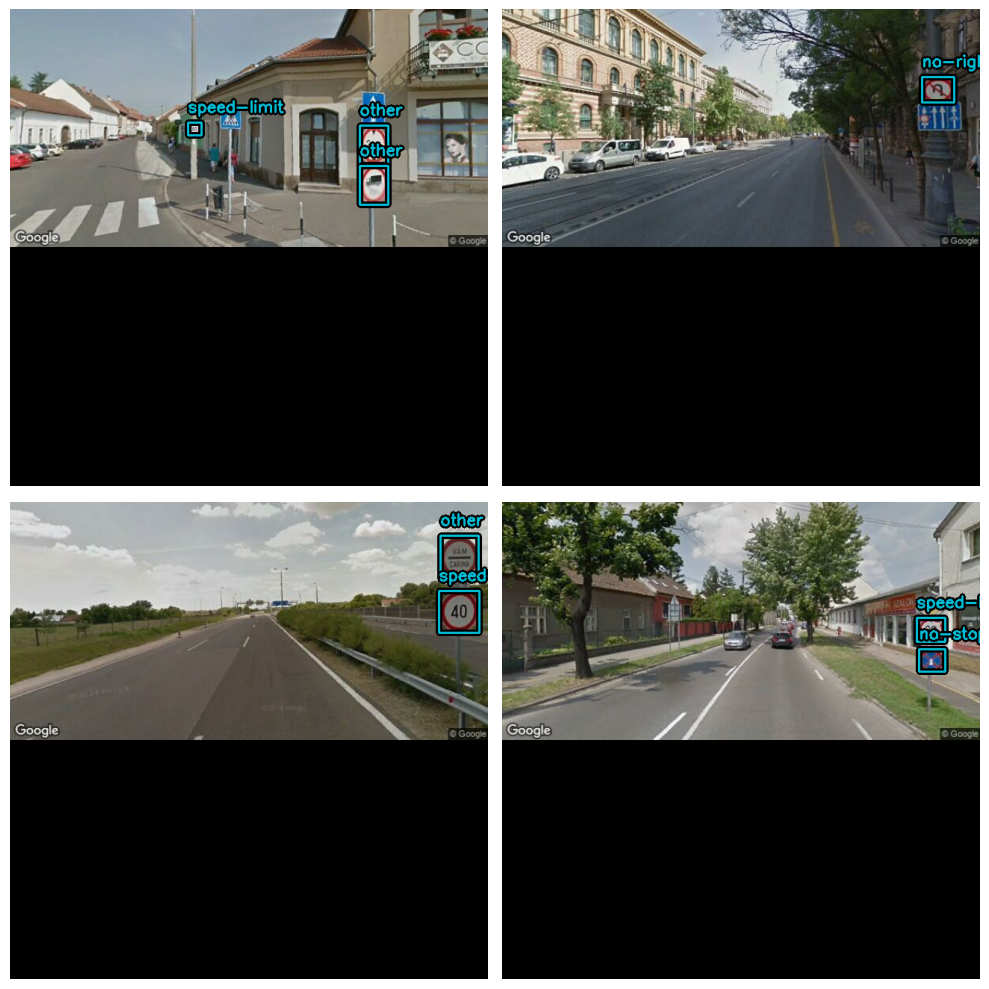

In [18]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    """
    Function to visualize the dataset
    :param inputs: Dataset to visualize
    :param value_range: Range of values to plot
    :param rows: Number of rows in the plot
    :param cols: Number of columns in the plot
    :param bounding_box_format: Format of the bounding boxes
    """
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

visualize_dataset(
    train_ds,
    bounding_box_format=config["bbox_format"],
    value_range=(0, 255),
    rows=2, cols=2
)

visualize_dataset(
    val_ds,
    bounding_box_format=config["bbox_format"],
    value_range=(0, 255),
    rows=2, cols=2
)

visualize_dataset(
    test_ds,
    bounding_box_format=config["bbox_format"],
    value_range=(0, 255),
    rows=2, cols=2
)

In [19]:
def dict_to_tuple(inputs):
    """
    Function to convert the dictionary to a tuple
    :param inputs: Dictionary to convert
    :return: Tuple containing the image and bounding boxes
    """
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

# Implementing the YOLOv8 model in Keras

In [20]:
 def build_model():
    """
    Builds the yolo model from the yolo_v8_s_coco backbone
    :return: yolo model with the first 150 layers frozen
    """
    prediction_decoder = keras_cv.layers.NonMaxSuppression(
        bounding_box_format=config["bbox_format"],
        from_logits=True,
        # Decrease the required threshold to make predictions get pruned out
        iou_threshold=config['iou_threshold'],
        # Tune confidence threshold for predictions to pass NMS
        confidence_threshold=config['confidence_threshold'],
    )
    
    # For transfer learning, we load the YOLOv8 weights trained on the COCO dataset
    yolo = keras_cv.models.YOLOV8Detector.from_preset(
        preset="yolo_v8_s_backbone_coco",    # A small YOLOV8 backbone with 5.09 million parameters. Ref: https://keras.io/api/keras_cv/models/backbones/yolo_v8/
        num_classes=config['num_classes'],    # The number of neurons in the last layer
        bounding_box_format=config["bbox_format"],
        prediction_decoder=prediction_decoder,
        fpn_depth=1,
    )

    optimizer = Adam(
        learning_rate=config['learning_rate'],
        global_clipnorm=config['global_clipnorm'],
    )

    # Freeze the first layers out of the 145
    for layer in yolo.layers[:config['freeze_layers']]:
        layer.trainable=False

    yolo.compile(
        optimizer=optimizer,
        classification_loss="binary_crossentropy",
        box_loss="ciou",
    )    # User metrics is not supported yet for yolov8 so we have to use a callback for it
    # This mean that we can just write e.g.  metrics=['acccuracy'], inside the compile call
    
    return yolo

In [21]:
yolo = build_model()

yolo.summary()

Attaching 'config.json' from model 'keras/yolov8/keras/yolo_v8_s_backbone_coco/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/yolov8/keras/yolo_v8_s_backbone_coco/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/yolov8/keras/yolo_v8_s_backbone_coco/2' to your Kaggle notebook...
/opt/conda/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/opt/conda/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Model: "yolov8_detector"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 model (Functional)          {'P3': (None, None, None,    5089760   ['input_2[0][0]']             
                             128),                                                                
                              'P4': (None, None, None,                                            
                             256),                                                                
                              'P5': (None, None, None,                                            
                             512)}                                                  

## Implement Callbacks
### PyCOCOCallback

We will be using `PyCOCOCallback` from KerasCV to evaluate the model and calculate the
Map(Mean Average Precision) score, Recall and Precision. We also save our model when the
mAP score improves. [Source][1]

[1]: https://keras.io/guides/keras_cv/object_detection_keras_cv/

In [22]:
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    val_ds,
    bounding_box_format=config["bbox_format"],
)

early_stopping = EarlyStopping(
    patience=config['early_stopping_patience'], 
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath=config["checkpoint_path"],
    save_best_only=True,
    verbose=1
)

In [23]:
run = wandb.init(
    # Set the project where this run will be logged
    project="traffic-sign-recognition-with-kerascv",
    # Track hyperparameters and run metadata
    config=config,
)

# Run the wandb magic comand!
# This displays an embedding of the wandb run
%wandb

with tf.device(GPU_T4):
    history = yolo.fit(
        train_ds,
        validation_data=val_ds,
        epochs=config['num_epochs'],
        callbacks=[
            early_stopping,
            model_checkpoint,
            coco_metrics_callback,
            WandbMetricsLogger(log_freq=config['log_frequency']),
        ],
        shuffle=True,
    )

wandb: Currently logged in as: emmermarci (import_this). Use `wandb login --relogin` to force relogin


Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 19699.7617 - box_loss: 3.3541 - class_loss: 19696.4141
Epoch 1: val_loss improved from inf to 19250.89062, saving model to yolo-traffic-sign.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 27s 1s/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.48s).
Accumulating evaluation results...
DONE (t=0.14s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ I

In [24]:
# Re-batch the test dataset so that next(iter(test_ds.take(1))) takes the whole dataset
test_ds = test_ds.unbatch()
test_ds = test_ds.ragged_batch(len(test_df))

## Visualize detections

1/1 [==============================] - 7s 7s/step


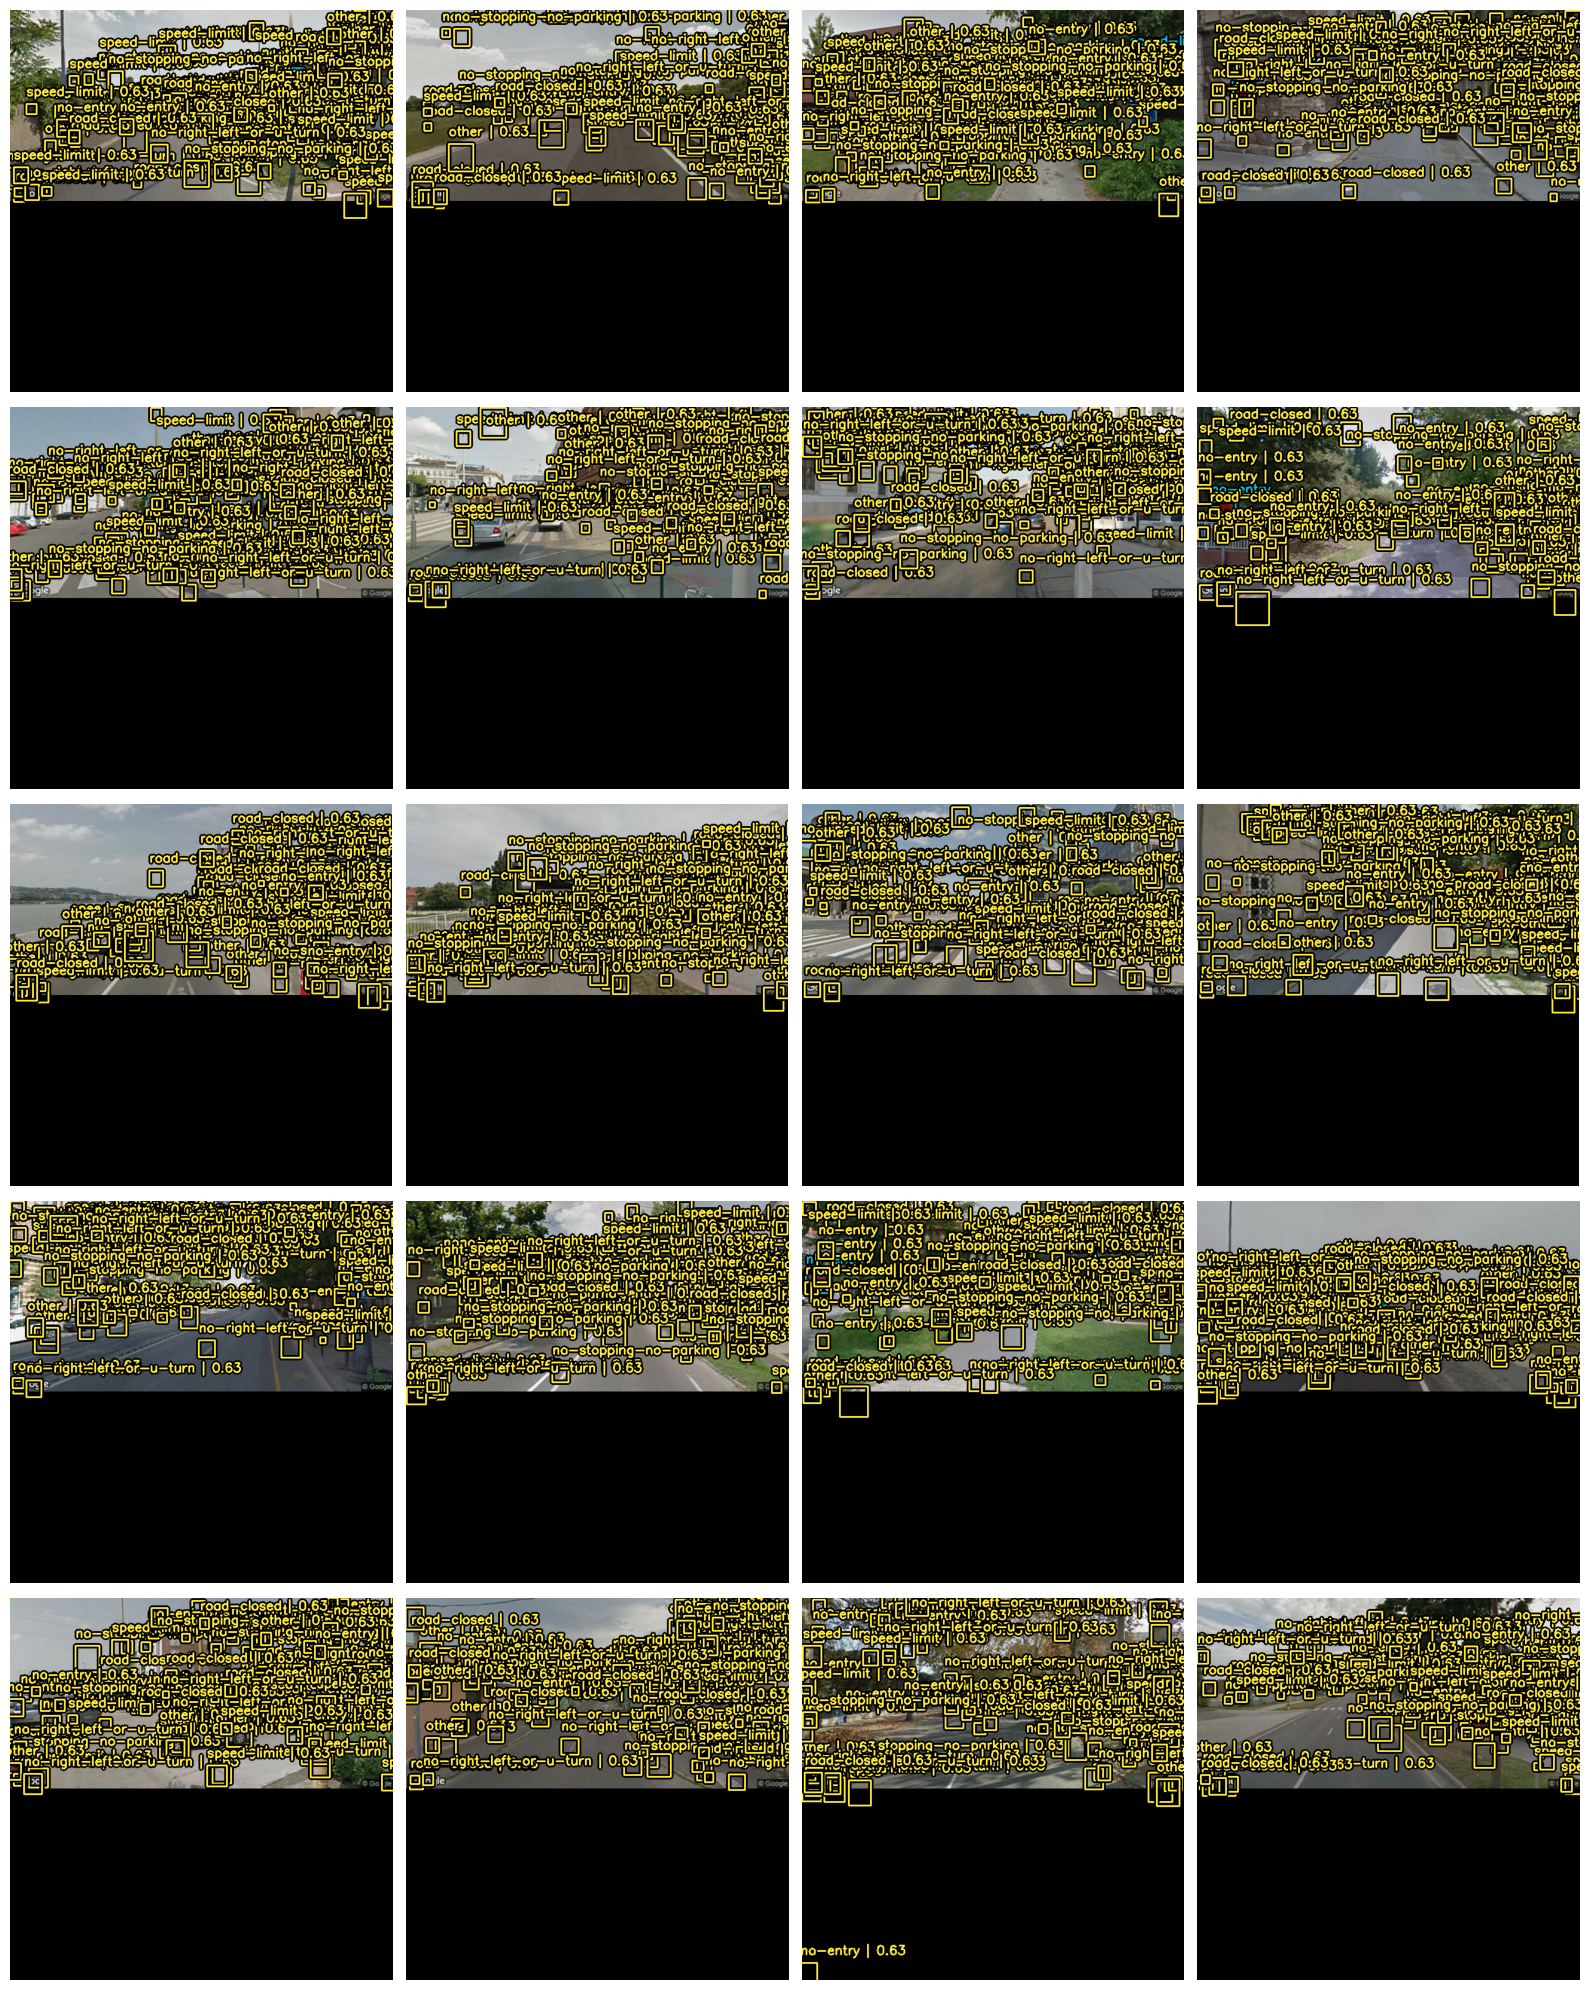

In [25]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=5,
        cols=4,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )
    


visualize_detections(
    yolo,
    dataset=test_ds,
    bounding_box_format=config["bbox_format"]
)

# Evaluation on the Test set

[Source][1]

[1]: https://towardsdatascience.com/object-detection-using-retinanet-and-kerascv-b07940327b6c

In [26]:
# only consider boxes with areas less than a 128x128 square.
coco_metrics = keras_cv.metrics.BoxCOCOMetrics(
    bounding_box_format=config["bbox_format"],
    evaluate_freq=config['eval_freq'],
)

# Evaluate the model on the test set
test_images, y_true = next(iter(test_ds.take(1))) 
y_pred = yolo.predict(test_images)        # Predict the bounding boxes

coco_metrics.update_state(y_true, y_pred) # Update the state of the metric
results = coco_metrics.result(force=True) # Get the results of the metric
results

1/1 [==============================] - 0s 409ms/step


{'MaP': <tf.Tensor: shape=(), dtype=float32, numpy=0.00074108096>,
 'MaP@[IoU=50]': <tf.Tensor: shape=(), dtype=float32, numpy=0.0049506132>,
 'MaP@[IoU=75]': <tf.Tensor: shape=(), dtype=float32, numpy=5.9358455e-05>,
 'MaP@[area=small]': <tf.Tensor: shape=(), dtype=float32, numpy=0.0012501957>,
 'MaP@[area=medium]': <tf.Tensor: shape=(), dtype=float32, numpy=0.0026585993>,
 'MaP@[area=large]': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'Recall@[max_detections=1]': <tf.Tensor: shape=(), dtype=float32, numpy=0.0031818182>,
 'Recall@[max_detections=10]': <tf.Tensor: shape=(), dtype=float32, numpy=0.03429293>,
 'Recall@[max_detections=100]': <tf.Tensor: shape=(), dtype=float32, numpy=0.047840167>,
 'Recall@[area=small]': <tf.Tensor: shape=(), dtype=float32, numpy=0.09888889>,
 'Recall@[area=medium]': <tf.Tensor: shape=(), dtype=float32, numpy=0.03>,
 'Recall@[area=large]': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}

In [27]:
results['MaP'].numpy()

0.00074108096

In [28]:
# log the evaluationm metrics
for key, value in results.items():
    run.log({'test_'+key: value.numpy()})
    
# Close the W&B run
run.finish()